#**Data**

**Loading Data**

In [1]:
# loading a datafile from your Google Drive directory
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive
%cd /gdrive/MyDrive/CIS509/A1

Mounted at /gdrive
/gdrive
/gdrive/MyDrive/CIS509/A1


In [2]:
import pandas as pd

# Use “political_orientation_data.json”. 
# converting datafile into a pandas dataframe
file = open("political_orientation_data.json", "r") # replace this path to open a data file
df = pd.read_json(file, lines=True) # representing data as a panda dataframe
df.head()

#df.shape


,text,label
0,"50 Years On, The Feminist Press Is Radical and...",Liberal
1,Anti-worker bills are working their way throug...,Liberal
2,The FBI Seized Almost $1 Million From This Fam...,Conservative
3,Stephanie Grisham’s Book Details Trump’s ‘Terr...,Liberal
4,How Trump kept peace,Conservative


# **logistic regression (text as the only source of input)**

**Data Preparation**

In [3]:
# Use Scikit-learn’s TF-IDF vectorizer to transform your data into numeric vectors 
# we can use TFKeras built-in vectorizer but scikit-learn's vectorizer is more straightforward

from sklearn.feature_extraction.text import TfidfVectorizer 
review_corpus = [] # store all reviews here so that we can fit the vectorizer with this dataset
y = []
count = 0
for index, row in df.iterrows():
  text = row['text'] 
  if row['label'] == "Liberal":
    label = 1 # Liberal
  else:
    label = 0 # Conservative
  review_corpus.append(text)
  y.append(label)
  count += 1
  if count == 5000:
    break

# Represent (i.e., quantify) each reddit post with a 10000-dimensional TF-IDF vector.
# the value of max_features is dependent on how you design your model  
vectorizer = TfidfVectorizer(max_features=10000) 
vectorizer.fit(review_corpus) # fit the vectorizer with the entire dataset

# once we fitted the vectorizer, we use it for converting raw text (review) into vectors
vectorized_review = vectorizer.transform(review_corpus)


In [4]:
print(vectorized_review.shape)
print(type(vectorized_review))
import numpy as np
X, Y = vectorized_review.toarray(), np.asarray(y) # convert both input (vectorized_review) and output (y) into numpy variables so that a TFkeras model can understand them

(5000, 10000)
<class 'scipy.sparse.csr.csr_matrix'>


**Model architecture**

In [5]:
import tensorflow as tf

#Input layer: shape 10000-d
input_layer = tf.keras.Input(shape=10000, name="input_layer")

#First hidden layer: shape 5000-d, activation function ReLU
hidden_layer_1 = tf.keras.layers.Dense(units=5000, activation="relu", name="hidden_layer_1")(input_layer)

#Second hidden layer: shape 2500-d, activation function ReLU
hidden_layer_2 = tf.keras.layers.Dense(units=2500, activation="relu", name="hidden_layer_2")(hidden_layer_1)

# output layer: shape 1-d, activation function that the model can solve a binary classification task
output_layer = tf.keras.layers.Dense(units=1, activation="sigmoid", name="output_layer")(hidden_layer_2)


**Model configuration**

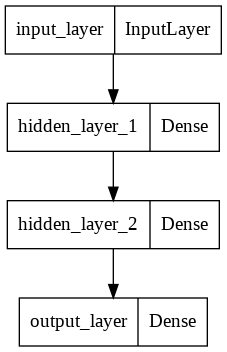

In [6]:
# Use binary cross-entropy loss as your model’s loss function and stochastic gradient descent as an optimizer. 
# Track accuracy for model evaluation.
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="ANN_political_orientation_with_two_hidden_layer")
model.compile(loss="binary_crossentropy", optimizer="SGD", metrics= tf.keras.metrics.BinaryAccuracy(name="accuracy"))

#model.summary()
tf.keras.utils.plot_model(model)


**Model development and evaluation**

In [7]:
# Customize the saving process during training
# A 75/25 split for training and testing, 30 epochs (set the batch size as 8) 
# Save the model producing the best result in terms of validation accuracy (use ModelCheckpoint for this).

filepath = "saved_model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_model", save_best_only=True, 
                                                 monitor="val_accuracy", mode="max", verbose=1) 

model.fit(x=X, y=Y, epochs=30, batch_size=8, validation_split=0.25, callbacks=cp_callback)


Epoch 1/30
469/469 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.6491
Epoch 1: val_accuracy improved from -inf to 0.64320, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets
469/469 [==============================] - 14s 22ms/step - loss: 0.6565 - accuracy: 0.6491 - val_loss: 0.6511 - val_accuracy: 0.6432
Epoch 2/30
468/469 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6496
Epoch 2: val_accuracy did not improve from 0.64320
469/469 [==============================] - 8s 17ms/step - loss: 0.6471 - accuracy: 0.6491 - val_loss: 0.6509 - val_accuracy: 0.6432
Epoch 3/30
468/469 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6490
Epoch 3: val_accuracy did not improve from 0.64320
469/469 [==============================] - 7s 16ms/step - loss: 0.6462 - accuracy: 0.6491 - val_loss: 0.6503 - val_accuracy: 0.6432
Epoch 4/30
467/469 [============================>.] - ETA: 0s - loss: 0.6453 -

**Model Load and reuse**

In [8]:
import tensorflow as tf
filepath = "saved_model"
new_model = tf.keras.models.load_model(filepath)
new_model.summary()

Model: "ANN_political_orientation_with_two_hidden_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 5000)              50005000  
                                                                 
 hidden_layer_2 (Dense)      (None, 2500)              12502500  
                                                                 
 output_layer (Dense)        (None, 1)                 2501      
                                                                 
Total params: 62,510,001
Trainable params: 62,510,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Classification results for the given new data
# Lable information : 1 = Liberal, 0 = Conservative

new_data = ["Anarcho-capitalism, in my opinion, is a doctrinal system which, if ever implemented, would lead to forms of tyranny and oppression that have few counterparts in human history",
            "Biden's Response to Putin's Invasion of Ukraine Has Been His Finest Moment"]

vectorized_new_data = vectorizer.transform(new_data)
new_x = vectorized_new_data.toarray()
new_model.predict(new_x)


array([[0.65138763],
       [0.02843174]], dtype=float32)